# Ejemplo LDA y QDA sobre datos de riesgo en auditorías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import copy

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

df = pd.read_csv('audit_data/trial.csv')
df.head()

,Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
0,3.89,23,4.18,6,2.50,2,6.68,5.0,2,3.38,2,2,0,2,0,2,2.4,1
1,3.89,6,0.00,2,4.83,2,4.83,5.0,2,0.94,2,2,0,2,0,2,2.0,0
2,3.89,6,0.51,2,0.23,2,0.74,5.0,2,0.00,2,2,0,2,0,2,2.0,0
3,3.89,6,0.00,2,10.80,6,10.80,6.0,6,11.75,6,2,0,2,0,2,4.4,1
4,3.89,6,0.00,2,0.08,2,0.08,5.0,2,0.00,2,2,0,2,0,2,2.0,0


## Diccionario de datos
<img src='images/audit_data_dict.png'>

**Fuente:** Hooda, Nishtha & Bawa, Seema & Rana, Prashant. (2018). Fraudulent Firm Classification: A Case Study of an External Audit. Applied Artificial Intelligence. 32. 10.1080/08839514.2018.1451032. 

In [2]:
df.shape

(776, 18)

In [3]:
df.describe()

,Sector_score,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,775.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000
mean,20.184536,2.450194,3.512887,10.799988,3.131443,13.218481,5.067655,2.237113,14.137631,2.909794,2.505155,0.029639,2.061856,0.104381,2.167526,2.702577,0.626289
std,24.319017,5.678870,1.740549,50.083624,1.698042,51.312829,0.264449,0.803517,66.606519,1.597452,1.228678,0.184280,0.375080,0.531031,0.679869,0.858923,0.484100
min,1.850000,0.000000,2.000000,0.000000,2.000000,0.000000,5.000000,2.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,2.370000,0.210000,2.000000,0.000000,2.000000,0.537500,5.000000,2.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,2.000000,2.000000,0.000000
50%,3.890000,0.875000,2.000000,0.405000,2.000000,1.370000,5.000000,2.000000,0.090000,2.000000,2.000000,0.000000,2.000000,0.000000,2.000000,2.400000,1.000000
75%,55.570000,2.480000,6.000000,4.160000,4.000000,7.707500,5.000000,2.000000,5.595000,4.000000,2.000000,0.000000,2.000000,0.000000,2.000000,3.250000,1.000000
max,59.850000,85.000000,6.000000,1264.630000,6.000000,1268.910000,9.000000,6.000000,935.030000,6.000000,6.000000,2.000000,6.000000,9.000000,6.000000,5.200000,1.000000


In [4]:
df.isna().sum()

Sector_score     0
LOCATION_ID      0
PARA_A           0
SCORE_A          0
PARA_B           0
SCORE_B          0
TOTAL            0
numbers          0
Marks            0
Money_Value      1
MONEY_Marks      0
District         0
Loss             0
LOSS_SCORE       0
History          0
History_score    0
Score            0
Risk             0
dtype: int64

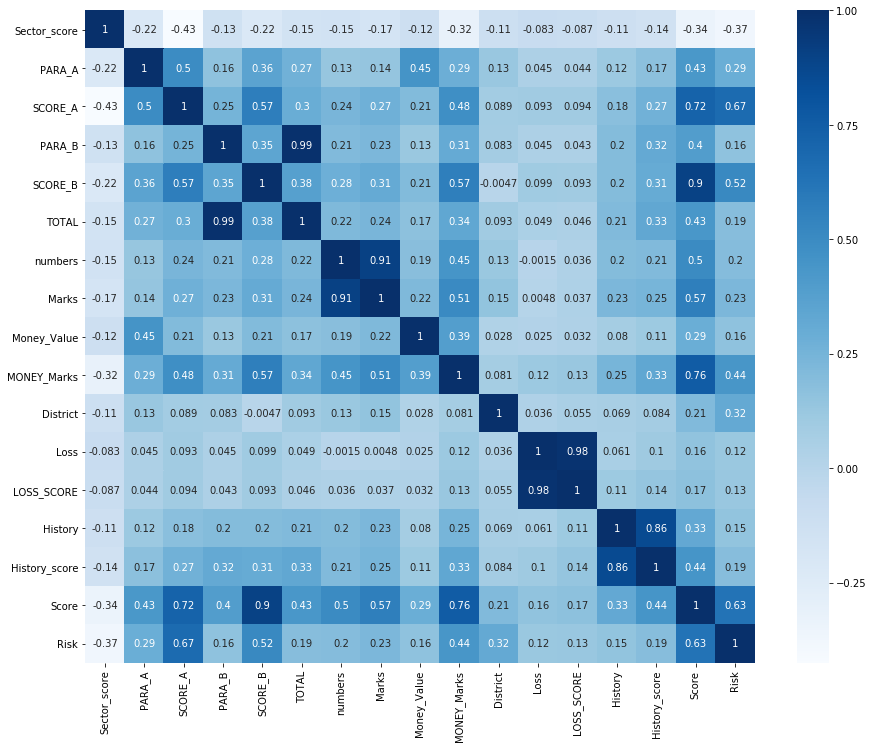

In [5]:
plt.figure(figsize = (15,12))
sn.heatmap(df.corr(), annot = True, cmap = 'Blues')

In [6]:
df_corr_filtered = df[['LOCATION_ID','Sector_score', 'PARA_A', 'PARA_B', 'numbers', 'Money_Value',
                       'District', 'Loss', 'History', 'Risk']]

In [7]:
df_corr_filtered.dtypes

LOCATION_ID      object
Sector_score    float64
PARA_A          float64
PARA_B          float64
numbers         float64
Money_Value     float64
District          int64
Loss              int64
History           int64
Risk              int64
dtype: object

In [8]:
df_dummies = pd.concat([df_corr_filtered, pd.get_dummies(df_corr_filtered['LOCATION_ID'], drop_first = True)],
                       axis = 1).drop('LOCATION_ID', axis = 1)

/Users/ignacio/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


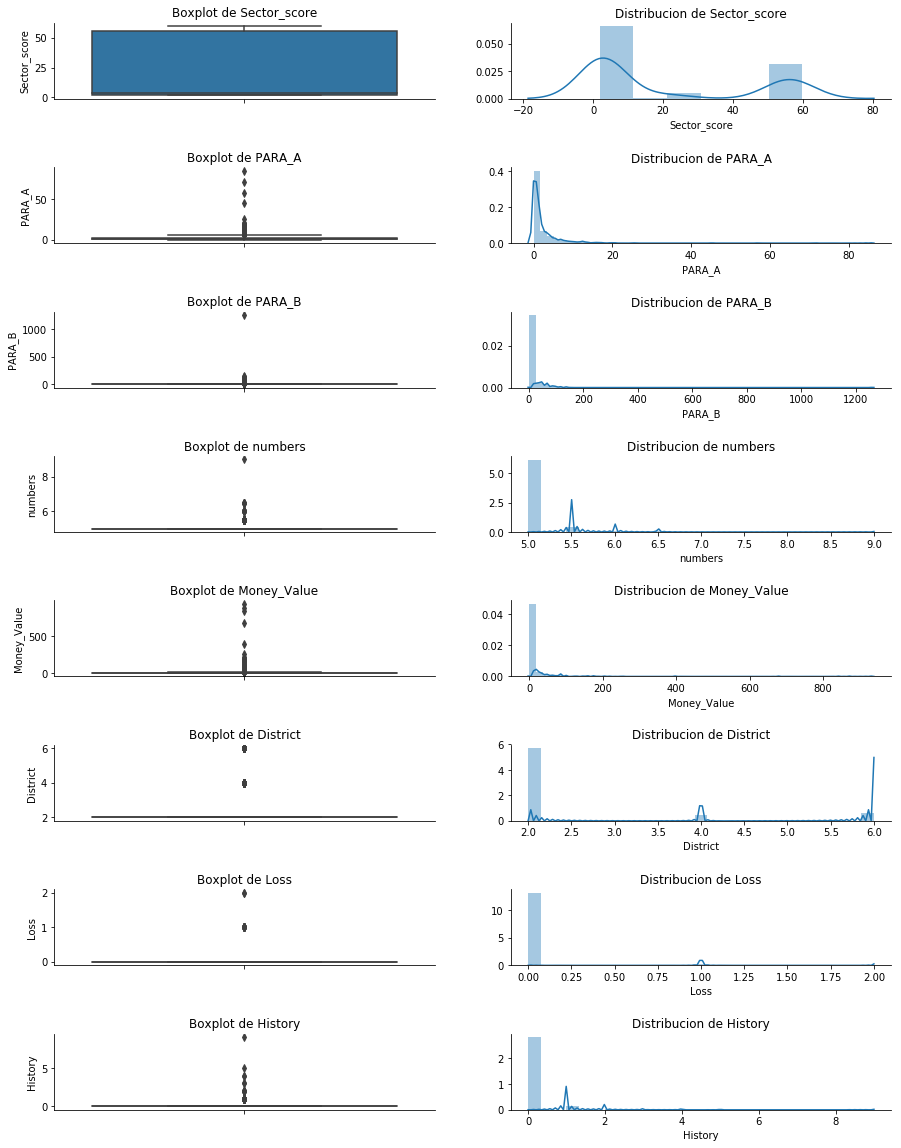

In [9]:
fig, ax = plt.subplots(8,2, figsize = (15,20))
plt.subplots_adjust(hspace = .9)
sn.despine()

for i, col in enumerate(df_dummies[['Sector_score', 'PARA_A', 'PARA_B', 'numbers', 'Money_Value', 'District',
                                    'Loss', 'History']]):
    ax[i][0].set_title('Boxplot de {0}'.format(col), size = 12)
    sn.boxplot(df_dummies[col].dropna(), orient = 'v', ax = ax[i][0])
    
    ax[i][1].set_title('Distribucion de {}'.format(col), size = 12)
    sn.distplot(df_dummies[col].dropna(), ax = ax[i][1])

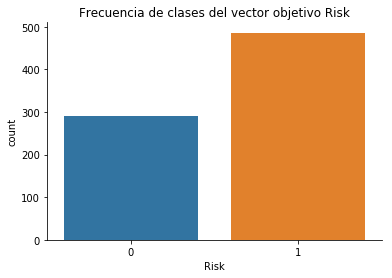

In [10]:
sn.countplot(df_dummies['Risk'])
sn.despine()
plt.title('Frecuencia de clases del vector objetivo Risk');

In [11]:
df_dummies.dropna(inplace = True)
x_train, x_test, y_train, y_test = train_test_split(df_dummies.loc[:, df_dummies.columns != 'Risk'],
                                                    df_dummies['Risk'],
                                                    test_size = .33,
                                                    random_state = 11235813)

# Baseline model: LDA and QDA with no class-imbalance correction

In [12]:
lda = LinearDiscriminantAnalysis(n_components=1, store_covariance=True).fit(x_train, y_train)
qda = QuadraticDiscriminantAnalysis().fit(x_train, y_train)

lda_preds = lda.predict(x_test)
qda_preds = qda.predict(x_test)

print('CR for baseline LDA:')
print(classification_report(y_test,lda_preds))
print('#####################################################\n')
print('CR for baseline QDA:')
print(classification_report(y_test,qda_preds))

CR for baseline LDA:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        99
           1       0.80      0.80      0.80       157

   micro avg       0.75      0.75      0.75       256
   macro avg       0.74      0.74      0.74       256
weighted avg       0.75      0.75      0.75       256

#####################################################

CR for baseline QDA:
              precision    recall  f1-score   support

           0       0.63      0.96      0.76        99
           1       0.96      0.64      0.77       157

   micro avg       0.77      0.77      0.77       256
   macro avg       0.80      0.80      0.77       256
weighted avg       0.83      0.77      0.77       256



/Users/ignacio/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ignacio/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/ignacio/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Incorporando información a priori

In [14]:
lda_prior_preds = LinearDiscriminantAnalysis(priors=[.5,.5]).fit(x_train, y_train).predict(x_test)

print('CR for baseline LDA with priors:')
print(classification_report(y_test,lda_prior_preds))

CR for baseline LDA with priors:
              precision    recall  f1-score   support

           0       0.68      0.85      0.75        99
           1       0.89      0.75      0.81       157

   micro avg       0.79      0.79      0.79       256
   macro avg       0.78      0.80      0.78       256
weighted avg       0.81      0.79      0.79       256



/Users/ignacio/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


# Oversampling with SMOTE

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=11235813, sampling_strategy = 'minority')

x_train_oversampled, y_train_oversampled = smote.fit_sample(x_train,y_train)

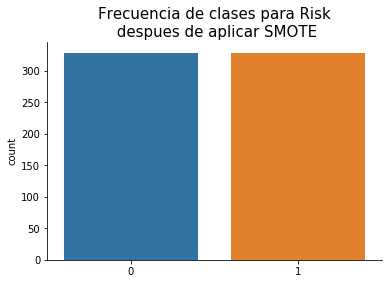

In [16]:

plt.title('Frecuencia de clases para Risk\n despues de aplicar SMOTE', size = 15)
sn.countplot(y_train_oversampled)
sn.despine();

In [17]:
df_oversampled = pd.DataFrame(x_train_oversampled, columns=df_dummies.loc[:,df_dummies.columns != 'Risk'].columns)
df_oversampled.shape

(658, 52)

In [18]:
x_train.shape

(519, 52)

/Users/ignacio/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


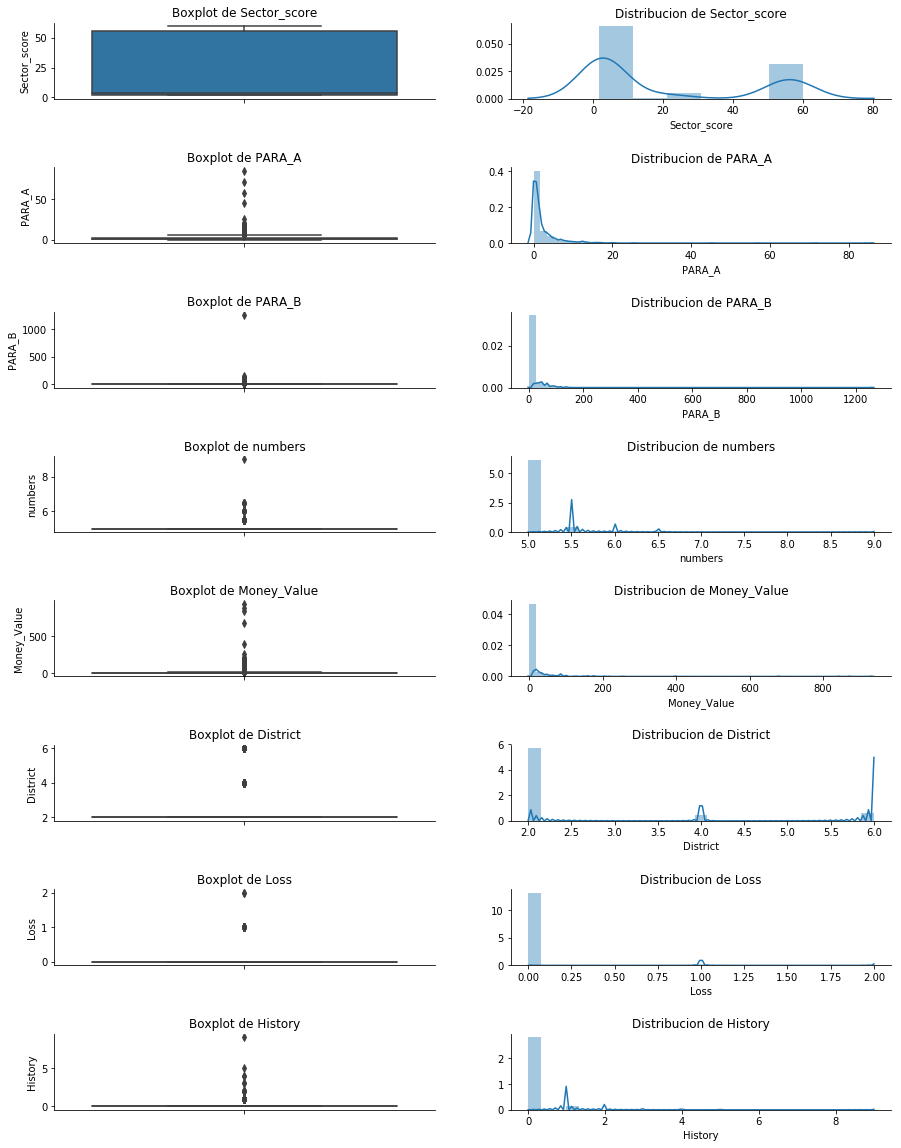

In [19]:
fig, ax = plt.subplots(8,2, figsize = (15,20))
plt.subplots_adjust(hspace = .9)
sn.despine()

for i, col in enumerate(df_oversampled[['Sector_score', 'PARA_A', 'PARA_B', 'numbers', 'Money_Value', 'District',
                                    'Loss', 'History']]):
    ax[i][0].set_title('Boxplot de {0}'.format(col), size = 12)
    sn.boxplot(df_dummies[col].dropna(), orient = 'v', ax = ax[i][0])
    
    ax[i][1].set_title('Distribucion de {}'.format(col), size = 12)
    sn.distplot(df_dummies[col].dropna(), ax = ax[i][1])

In [20]:
lda_smote = LinearDiscriminantAnalysis().fit(x_train_oversampled, y_train_oversampled)
qda_smote = QuadraticDiscriminantAnalysis().fit(x_train_oversampled, y_train_oversampled)

lda_smote_preds = lda_smote.predict(x_test)
qda_smote_preds = qda_smote.predict(x_test)


print('####################### LDA #############################\n')
print('* Baseline LDA:')
print(classification_report(y_test,lda_preds))
print('* Oversampled LDA:')
print(classification_report(y_test,lda_smote_preds))
print('######################## QDA ###########################\n')
print('* Baseline QDA:')
print(classification_report(y_test,qda_preds))
print('* Oversampled QDA:')
print(classification_report(y_test,qda_smote_preds))

####################### LDA #############################

* Baseline LDA:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        99
           1       0.80      0.80      0.80       157

   micro avg       0.75      0.75      0.75       256
   macro avg       0.74      0.74      0.74       256
weighted avg       0.75      0.75      0.75       256

* Oversampled LDA:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73        99
           1       0.88      0.70      0.78       157

   micro avg       0.76      0.76      0.76       256
   macro avg       0.76      0.77      0.76       256
weighted avg       0.79      0.76      0.76       256

######################## QDA ###########################

* Baseline QDA:
              precision    recall  f1-score   support

           0       0.63      0.96      0.76        99
           1       0.96      0.64      0.77       157

   micro avg  

/Users/ignacio/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ignacio/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/ignacio/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
